# Setup of Noteboook

The follwing code clones the github repository with course files. 
Subsequently it imports all libraries and custom modules needed for this notebook

In [211]:
!git clone https://github.com/DataHow/analytics-course-scripts.git
!pip install bayesian-optimization

fatal: destination path 'analytics-course-scripts' already exists and is not an empty directory.


In [332]:
# import libraries
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from scipy.stats import norm
from bayes_opt import BayesianOptimization, UtilityFunction

from functools import partial
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
import matplotlib.pyplot as plt
from matplotlib import gridspec


# Bayesian Optimization using Gaussian Processes

If every function evaluation is expensive, for instance when the parameters are the hyperparameters of a neural network and the function evaluation is the mean cross-validation score across ten folds, optimizing the hyperparameters by standard optimization routines would take for ever!

The idea is to approximate the function using a Gaussian process. In other words the function values are assumed to follow a multivariate gaussian. The covariance of the function values are given by a GP kernel between the parameters. Then a smart choice to choose the next parameter to evaluate can be made by the acquisition function over the Gaussian prior which is much quicker to evaluate.



## Problem Definition

We are interested in solving

\begin{align}x^* = arg \min_x f(x)\end{align}

under the constraints that:

*   $f$ is a black box for which no closed form is known (nor its gradients)
*   $f$ is expensive to evaluate
*   evaluations of $y=f(x)$ may be noisy





# Create function to optimize

Here we first create an originator function that's nonlinear with addition of noise.

In [3]:
# Fix seed
np.random.seed(42)
# Function definition
xgrid = np.round(np.arange(-3,3,0.01),4)
def f(x,eps=0):
    return -1*np.power(x,4)+0.5*np.power(x,3)+6*np.power(x,2)+0.5*np.power(x,1)-6+eps*np.random.normal(0,1,x.size)


In [4]:
# Plot function to optimize
fgrid = f(xgrid)
fig = px.line(x=xgrid,y=fgrid,title="Function to Optimize")
fig.update_yaxes(range=[-10, 10])
fig.show()

The goal is to find maximum. If we could sample unlimited times our datapoints x, we could just look up the answer.

In [5]:
maxloc = np.argmax(f(xgrid))
maxval = xgrid[maxloc]
maxfun = f(maxval)
print('The maxium is at x = ',maxval)
print('The value of f at that point is y = ',maxfun)

The maxium is at x =  1.95
The value of f at that point is y =  [7.03843125]


### Add experimental points

Define initial experimental points

In [6]:
# Control of noise level
eps = 0.5
# Define experimental observations
x = np.arange(-3,0.5,0.5)


In [7]:
# Obtain observation measurments with noise
y = f(x,eps)
# Plot funcition with measurments
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10),name='Measurements'))
fig.update_yaxes(range=[-10, 10])
fig.update_layout(title="Unknown function with measurments",xaxis_title="x",yaxis_title="y")
fig.show()

### Fit gaussian process model

We use gausian processes with standard normal kernel to learn the function above given those measurments.

In [8]:
# Define Model
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-2, 1e1))
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0, alpha=0, n_restarts_optimizer=3).fit(x.reshape(-1,1), y.reshape(-1,1)) 
# Use model to make predictions
xpred = xgrid
ypred = np.zeros((3,len(xpred)))
for n in range(len(xpred)):
    (mean,std)=gpr.predict(xgrid[n].reshape(-1,1),return_std=True) 
    ypred[1,n] = mean.flatten()
    ypred[0,n] = mean.flatten()-2*std.flatten()
    ypred[2,n] = mean.flatten()+2*std.flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.



In [9]:
# Plot predictions
fig = go.Figure()
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color=px.colors.qualitative.G10[3]),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color=px.colors.qualitative.G10[3]),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color=px.colors.qualitative.G10[0]),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color=px.colors.qualitative.G10[1]),name='Measurements'))
fig.update_yaxes(range=[-10, 10])
fig.update_xaxes(range=[-3, 3])
fig.update_layout(title="Learned function from observations",xaxis_title="x",yaxis_title="y")
fig.show()

# Define acquisition function

Acquisition function represent our objective.



## Probability of improvement.

A example of good acquisition function is a probability of improvement.

\begin{align} PI(x) = 1-P(f(x)\geq f(x_t^+ + \kappa)) \end{align}

To demonstrate it, let's evaluate the function at some new point.

In [43]:
# New measurments
xnew = 1

In [44]:
# Obtain prediction at the new point
(ynew_mean,ynew_std) = gpr.predict(np.array(xnew).reshape(1,-1),return_std=True)
print('Predicted mean and std at x = '+str(xnew))
print("Mean: ",float(ynew_mean))
print("Std: ",float(ynew_std))

Predicted mean and std at x = 1
Mean:  10.422362845362386
Std:  10.013013082135775


We compare now this prediction with actual maximal value observed so far.

In [45]:
# Actual maximum value
y_max = np.max(y)
print("Observed maximum function value so far at y = "+str(round(y_max,4)))

Observed maximum function value so far at y = 0.0244


### Compute distribution

Therefore we compute distribution of possible values. Since we know our prediction at each new point `xnew` is normally distributed with `xnew_mean` and `xnew_std`, we can plot the full distribution at the new point. 

This distribution represents possible observations according to the model. The solid red line represents a so far actualy observed maximum value `y_max`.




In [46]:
# Compute normal distribution
xdist = np.random.randn(100000)*float(ynew_std) + float(ynew_mean)
hist_data = [xdist]
group_labels = ['Conditional Distribution'] 

# Plot distribution
fig = ff.create_distplot(hist_data, group_labels,curve_type='normal',show_hist=False, show_rug=False)
fig.add_vline(x=float(ynew_mean),line=dict(color='green'),annotation=dict(text="Mean",textangle=90))
fig.add_vline(x=float(ynew_mean)+float(ynew_std),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
fig.add_vline(x=float(ynew_mean)-float(ynew_std),line=dict(color='green',dash='dash'),annotation=dict(text="Std",textangle=90))
fig.add_vline(x=float(y_max),line=dict(color='red'),annotation=dict(xanchor="right",text="Observed Maximum Value",textangle=90))
fig.update_layout(title="Conditional distribution at x = "+str(xnew),showlegend=True,xaxis_title="x",yaxis_title="pdf")
fig.show()


Now we compute the accquisition function based on the conditional probability distribution as probability of improvement. That is a probability of observing a value from the conditional distribution greater than the observed maximum value is:

In [15]:
# Probability of improvement
PI = 1-norm(float(ynew_mean), float(ynew_std)).cdf(y_max)
print("Probability of Improvement = "+str(PI))

Probability of Improvement = 0.8504678256089069


### Compute acquisition for all x

Now we compute the acquisition function for all x values


In [16]:
# Calculate PI (Probability of Improvement)
pigrid = np.zeros_like(xgrid)
for n in range(len(xgrid)):
    pigrid[n] = 1-norm(float(ypred[1,n]), float((ypred[1,n]-ypred[0,n])/2)).cdf(y_max)

In [17]:
# Plot acquisition function (PI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=pigrid,mode='lines',line=dict(color='red'),name='Probability of Improvement'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes(range=[0,1], secondary_y=True,title_text="Probability of Improvement")
fig.update_layout(title="Acquisition function (Probability of Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


Given the defined acquisition function, then next point we would like to observe a measurment from is value for which the acquisition function is the highest.

In [18]:
pimaxloc = np.argmax(pigrid)
pimaxval = xgrid[pimaxloc]
pimaxfun = pigrid[pimaxloc]
print('The maximum PI is at x = ',pimaxval)
print('The Prob of improvement at that point is y = ',pimaxfun)

The maximum PI is at x =  1.19
The Prob of improvement at that point is y =  0.8613476680004005


## Expected improvement

Here we modify our acquisition function to be an expected improvement. That is an actual value of the function by which we expect to improve discounted by their conditional probabilities.

\begin{align} EI(x) = E\left[ f(x) - f(x_t^+) - \kappa \right]\end{align}


In [19]:
# Calculate EI (Expected Improvement)
eigrid = np.zeros_like(xgrid)
xi = 0.1
for n in range(len(xgrid)):
    sigma = float((ypred[1,n]-ypred[0,n])/2)
    zscore = (float(ypred[1,n])-y_max-xi) / sigma
    phiz = norm(0,1).cdf(zscore)
    eigrid[n] = (float(ypred[1,n])-y_max-xi)*phiz + sigma*phiz

In [20]:
# Plot acquisition function (EI)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eigrid,mode='lines',line=dict(color='red'),name='Expected Improvement'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Expected Improvement")
fig.update_layout(title="Acquisition function (Expected Improvement) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


## Exploration / Exploitation

You can define your own acquisition function. The function demonstrated below is a balanced approach between exploration and exploitation which is driven by parameter $\kappa$ = `kappa`. The values correspond to the upper confidence bounds.

\begin{align} UCB(x) = \mu_{GP}(x) + \kappa * \sigma_{GP}(x)\end{align}



In [53]:
# Explore-Exploit parameter
kappa = 0.5

In [51]:
# Calculate EE (Explore-Exploit)
eegrid = ypred[1,:] + kappa*((ypred[1,n]-ypred[0,n])/2)

In [52]:
# Plot acquisition function (EE)
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=xgrid,y=ypred[1,:],mode='lines', line=dict(width=2,color='green'),name='Mean prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[0,:],mode='lines', line=dict(width=0,color='green'),showlegend=False))
fig.add_trace(go.Scatter(x=xgrid,y=ypred[2,:],mode='lines', line=dict(width=0,color='green'),fill='tonexty',name='Std prediction'))
fig.add_trace(go.Scatter(x=xgrid,y=fgrid,mode='lines',line=dict(dash='dash',color='blue'),name='Unknown function'))
fig.add_trace(go.Scatter(x=x,y=y,mode='markers',marker=dict(size=10,color='red'),name='Measurements'))
fig.add_trace(go.Scatter(x=xgrid,y=eegrid,mode='lines',line=dict(color='red'),name='Explore-Exploit'),secondary_y=True)
fig.update_xaxes(range=[-3, 3])
fig.update_yaxes(range=[-10, 10], secondary_y=False)
fig.update_yaxes( secondary_y=True,title_text="Explore-Exploit")
fig.update_layout(title="Acquisition function (Explore-Exploit) for all x",xaxis_title="x",yaxis_title="y")
fig.show()


# Run Bayesian Optimization

Now that we have have defined the optimization problem, we can run the bayesian optimization and see if we are able to iteratively find the maximum possible value.


## Target function

Lets create a target 1-D function with multiple local maxima to test and visualize how the BayesianOptimization package works. The target function we will try to maximize is the following:

\begin{align} f_1(x) = -1x^4 + 0.5x^3 + 6x^2+ 0.5x-6 +\epsilon \end{align}
\begin{align} f_2(x) = e^{-(x-2)^2} + e^{-0.1(x-6)^2}+ 1/(x^2+1)\end{align}

the maximum of both is around $x=2$ and we will restrict the interval of interest to $x_{f_1} \in (-3,3)$ and $x_{f_2} \in (-2,10)$

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [539]:
# Specify noise level
eps = 0.5
# Function to optimize
def f(x,eps=eps):
    x = np.array(x)
    return -1*(x**4)+0.5*(x**3)+6*(x**2)+0.5*x-6 + eps*np.random.normal(0,1,x.shape) # domain (-3,3)
    #return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)   # domain (-2,10)
    #return np.sin(x)/2 - ((10 - x)**2)/50 + 2
# Specify domain
domain = (-3,3)
#domain = (-2,10)
#domain = (0,20)
xgrid = np.linspace(domain[0],domain[1],1000)
# Plot true function
fig = px.scatter(x=xgrid,y=f(xgrid,eps=0).flatten())
fig.show()

Enter the target function to be maximized, its variable(s) and their corresponding ranges. A minimum number of 2 initial guesses is necessary to kick start the algorithms, these can either be random or user defined.

In [540]:
# Define model
#kernel = Matern(length_scale=1.0)
#regressor = GaussianProcessRegressor(kernel=kernel)

# Define optimizer
optimizer = BayesianOptimization(f, {'x': domain}, random_state=np.random.seed(47),verbose=2)
optimizer._gp.set_params(**dict(alpha=1))
optimizer.maximize(init_points=2, n_iter=30,acq='ei', alpha=1e-3, n_restarts_optimizer=3)


|   iter    |  target   |     x     |
-------------------------------------
|  1        | -2.273    |  2.627    |
|  2        | -1.699    | -1.952    |
|  3        | -0.2203   |  0.9309   |
|  4        |  0.1359   |  0.9815   |
|  5        | -0.7112   |  0.9816   |
|  6        |  0.714    |  0.9815   |
|  7        | -1.186    |  0.9313   |
|  8        |  0.2255   |  0.9813   |
|  9        | -0.3384   |  0.9808   |
|  10       | -0.481    |  0.9815   |
|  11       | -0.8818   |  0.9815   |
|  12       | -0.1296   |  0.931    |
|  13       | -0.6523   |  0.9813   |
|  14       | -0.6615   |  0.981    |
|  15       | -4.855    | -0.4556   |
|  16       |  0.2123   |  0.9814   |
|  17       |  0.1685   |  0.9808   |
|  18       | -0.1477   |  0.9808   |
|  19       | -3.307    |  2.653    |
|  20       | -0.6583   |  0.9307   |
|  21       | -1.1      |  0.9817   |
|  22       | -0.02035  |  0.9815   |
|  23       |  0.05298  |  0.9814   |
|  24       | -0.1008   |  0.9814   |
|  25       

In [541]:
print("Optimal point found by optimizaiton at x = "+str(round(optimizer.max['params']['x'],4)))
print("Functional value at optimum f(x) = "+str(round(optimizer.max['target'],4)))

Optimal point found by optimizaiton at x = 0.9815
Functional value at optimum f(x) = 0.714


## Convergence plot

In [542]:
func_vals = [out['target'] for out in optimizer.res]
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,len(func_vals)+1)),y=np.maximum.accumulate(func_vals)))
fig.update_layout(title="Convergence Plot",xaxis_title="Number of iterations", yaxis_title="max f(x) after n iterations")

## Acquisition function progression

In [543]:
# Define plotting functions
def posterior(optimizer, x_obs, y_obs, grid):
    optimizer._gp.fit(x_obs, y_obs)

    mu, sigma = optimizer._gp.predict(grid, return_std=True)
    return mu, sigma

def plot_gp(optimizer, x, y):
    fig = plt.figure(figsize=(16, 10))
    steps = len(optimizer.space)
    fig.suptitle(
        'Gaussian Process and Utility Function After {} Steps'.format(steps),
        fontdict={'size':30}
    )
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    x_obs = np.array([[res["params"]["x"]] for res in optimizer.res])
    y_obs = np.array([res["target"] for res in optimizer.res])
    
    mu, sigma = posterior(optimizer, x_obs, y_obs, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(x_obs.flatten(), y_obs, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((domain[0], domain[1]))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility_function = UtilityFunction(kind="ucb", kappa=5, xi=0)
    utility = utility_function.utility(x, optimizer._gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((domain[0], domain[1]))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)



Define Optimization we investigate sequentially

In [575]:
# Plot defaults
x = xgrid.reshape(-1, 1)
y = f(xgrid,eps=0)
# Define acquisition funciton
acq_kappa = 2
acq_fun = 'ei' # [ucb, ei, poi]
acq_xi = 0.1
# Define Optimization
optimizer = BayesianOptimization(f, {'x': domain}, random_state=np.random.seed(47),verbose=2)
optimizer.maximize(init_points=2, n_iter=0, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
# Modify Model
kernel=Matern(length_scale=1, nu=2.5, length_scale_bounds=(1e-3,1e3))
optimizer._gp.set_params(**dict(alpha=0.1,kernel=kernel))


|   iter    |  target   |     x     |
-------------------------------------
|  1        | -10.06    |  2.837    |
|  2        |  7.625    |  2.016    |


GaussianProcessRegressor(alpha=0.1, kernel=Matern(length_scale=1, nu=2.5),
                         n_restarts_optimizer=5, normalize_y=True,
                         random_state=RandomState(MT19937) at 0x7FD301D3F9E0)

### Two random points

After we probe two points at random, we can fit a Gaussian Process and start the bayesian optimization procedure. Two points should give us a uneventful posterior with the uncertainty growing as we go further from the observations.

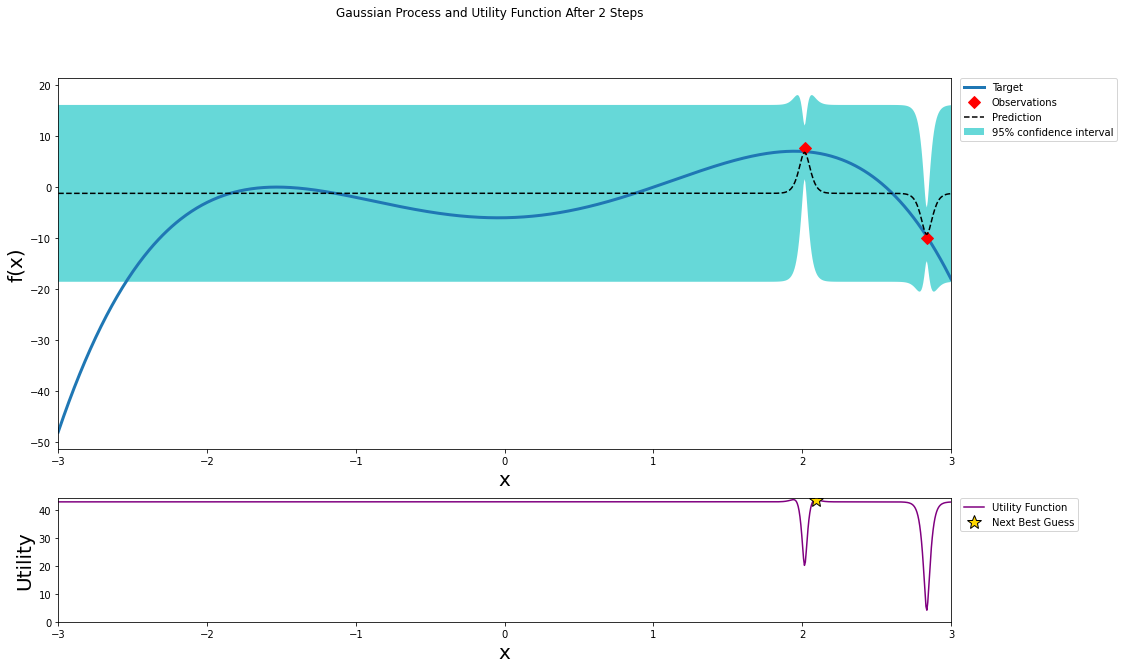

In [576]:
plot_gp(optimizer, x, y)

### After one step of GP

|   iter    |  target   |     x     |
-------------------------------------
|  3        |  7.462    |  2.0      |


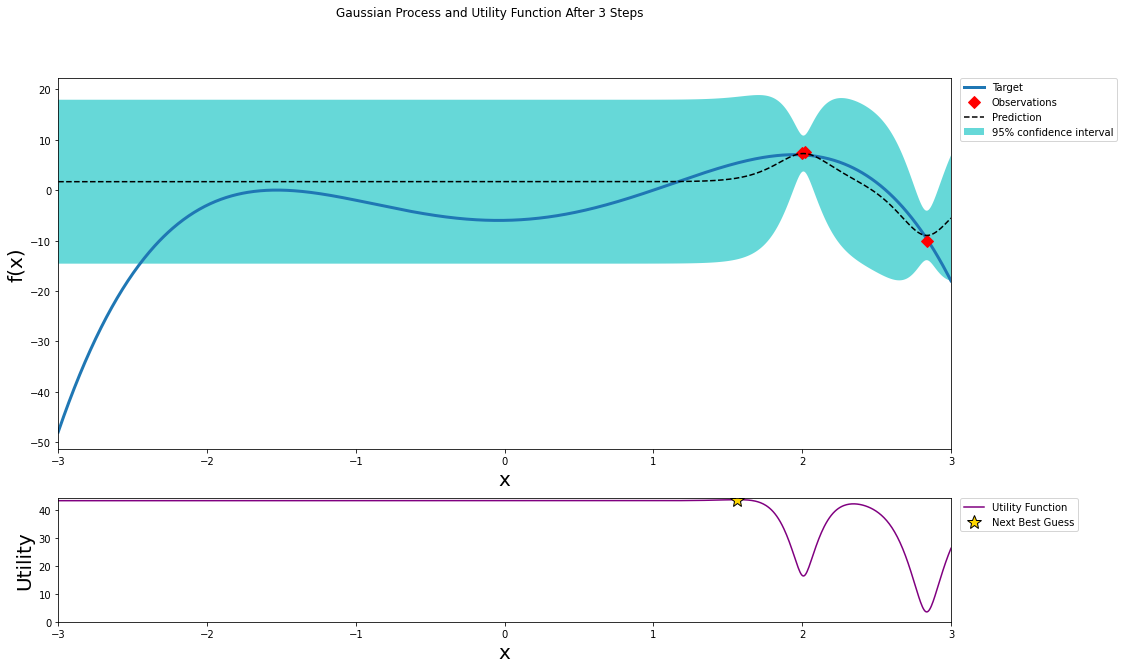

In [577]:
optimizer.maximize(init_points=0, n_iter=1,kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)

### After two steps of GP

|   iter    |  target   |     x     |
-------------------------------------
|  4        |  7.061    |  1.795    |


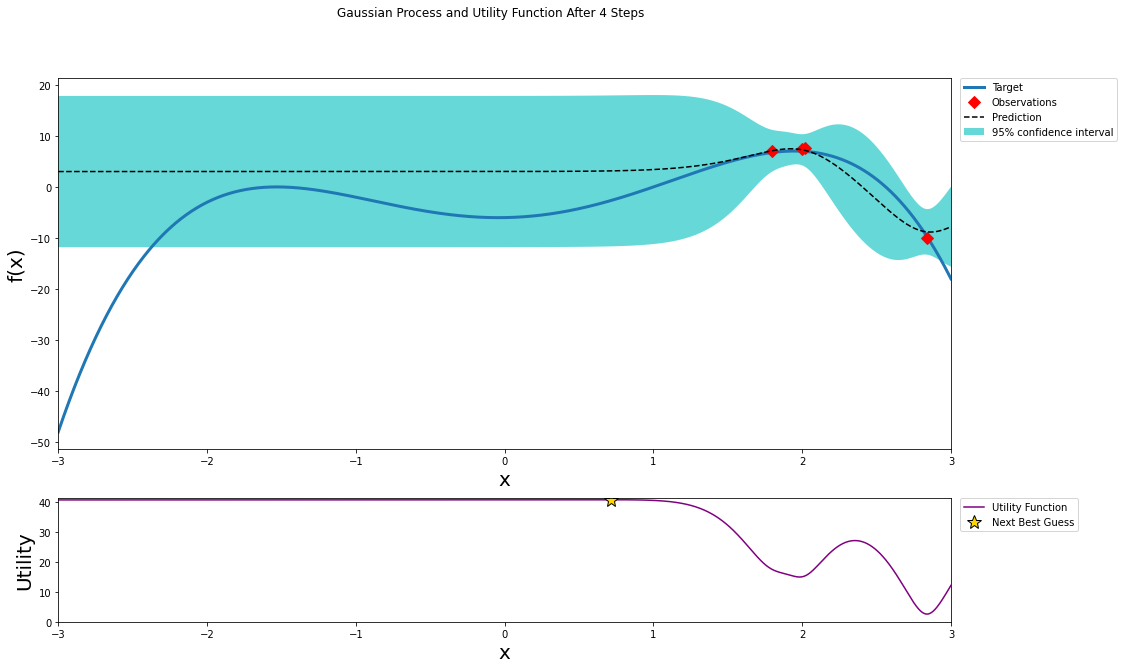

In [578]:
optimizer.maximize(init_points=0, n_iter=1, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)

### After three steps of GP


|   iter    |  target   |     x     |
-------------------------------------
|  5        |  1.315    |  1.181    |


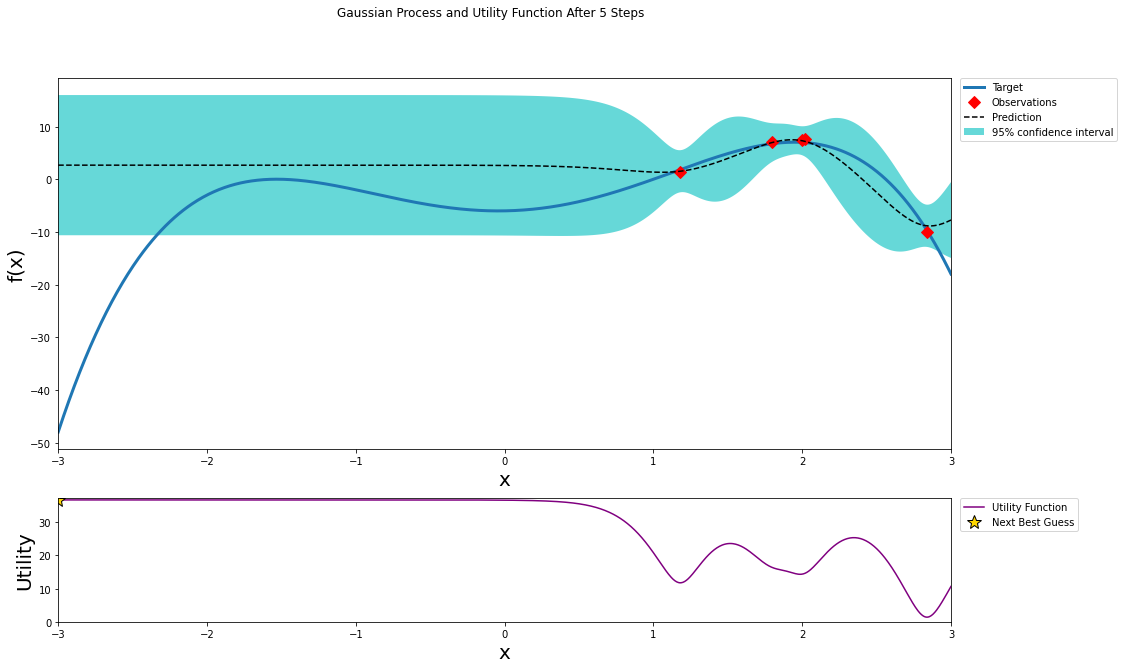

In [579]:
optimizer.maximize(init_points=0, n_iter=1, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)

### After four steps of GP


|   iter    |  target   |     x     |
-------------------------------------
|  6        | -47.1     | -3.0      |


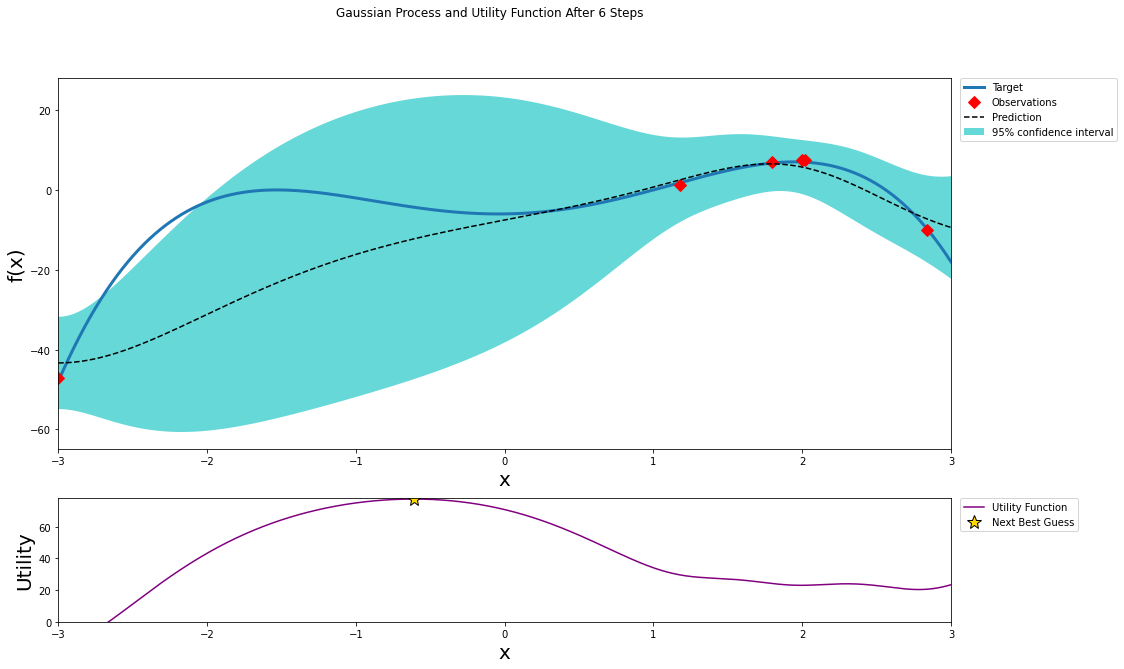

In [580]:
optimizer.maximize(init_points=0, n_iter=1, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)

### After five steps of GP

|   iter    |  target   |     x     |
-------------------------------------
|  7        | -6.453    | -0.1466   |


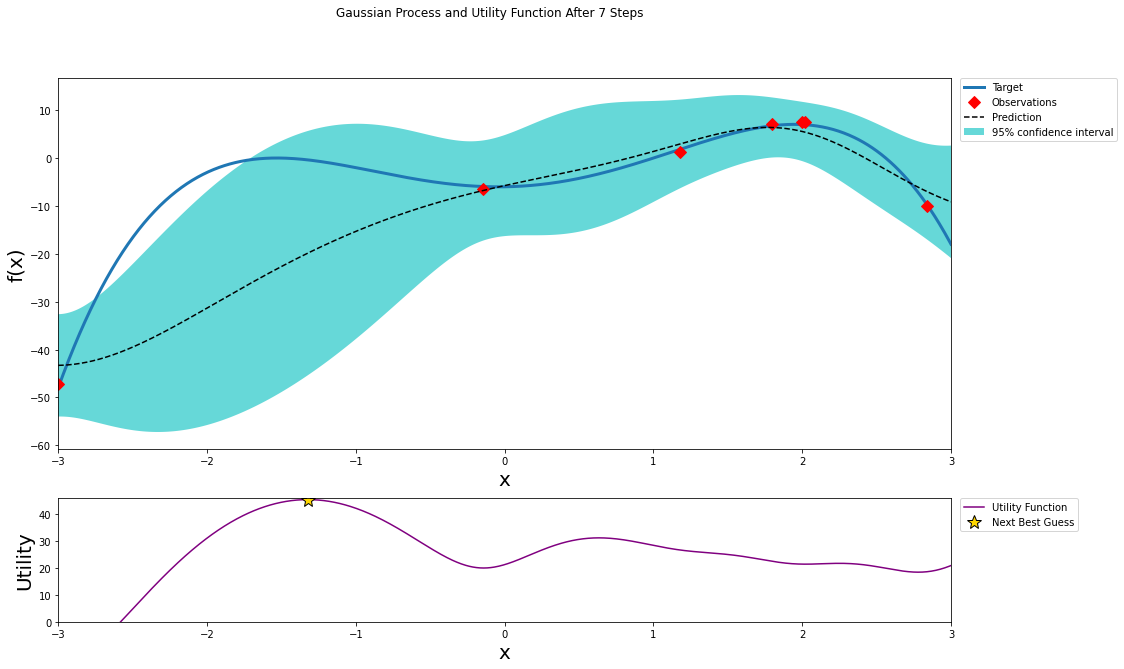

In [581]:
optimizer.maximize(init_points=0, n_iter=1, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)

### After 50 steps of GP

|   iter    |  target   |     x     |
-------------------------------------
|  8        |  6.55     |  1.673    |
|  9        |  6.107    |  1.693    |
|  10       |  6.121    |  1.723    |
|  11       |  5.932    |  1.767    |
|  12       |  7.424    |  1.835    |
|  13       |  6.509    |  1.879    |
|  14       |  5.494    |  1.646    |
|  15       |  7.256    |  1.953    |
|  16       |  7.436    |  1.951    |
|  17       |  7.398    |  1.951    |
|  18       |  7.082    |  1.95     |
|  19       |  6.377    |  1.944    |
|  20       | -1.335    | -1.111    |
|  21       |  5.99     |  2.043    |
|  22       |  7.099    |  1.86     |
|  23       |  7.187    |  1.866    |
|  24       | -3.014    |  0.6605   |
|  25       |  6.439    |  1.834    |
|  26       |  7.446    |  2.005    |
|  27       |  7.183    |  1.877    |
|  28       |  5.873    |  2.013    |
|  29       |  5.95     |  1.805    |
|  30       |  7.009    |  1.827    |
|  31       |  6.699    |  2.034    |
|  32       

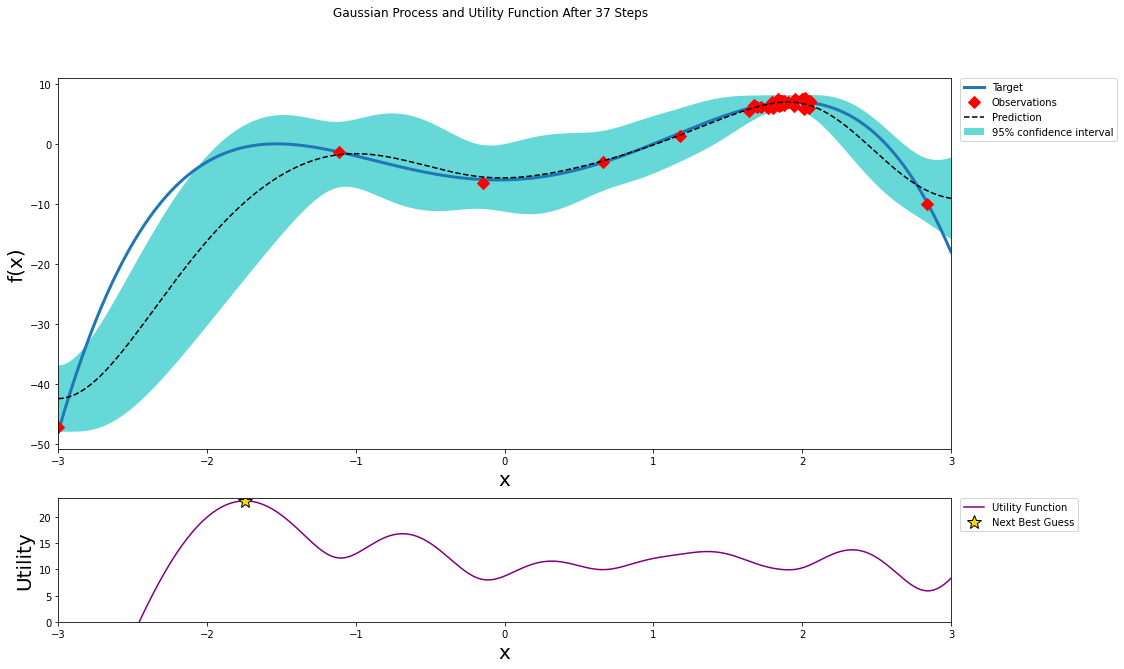

In [582]:
optimizer.maximize(init_points=0, n_iter=30, kappa=acq_kappa, acq=acq_fun, xi=acq_xi)
plot_gp(optimizer, x, y)